In [5]:
import boto3
import requests
import os
import geopandas as gpd
import io
import json
# set this to your own directory
os.chdir("/Users/canyonfoot/Documents/python_proj/nwf-process-geodata")

In [6]:
boto3.__version__

'1.34.80'

You will need to copy your secrets AWS credentials into a json file `secrets/aws_secrets` structured like this:

{
    "Version": 1,
    "AccessKeyId": [ACCESS_KEY],
    "SecretAccessKey": [SECRET_KEY],
    "Region": "us-east-1"
}

Be careful to not share these - the folder is gitignored and you should never push any notebook in which the key values are printed out.

In [7]:
secrets_path = 'secrets/aws_secrets.json'

with open(secrets_path, 'r') as file:
    aws_creds = json.load(file)

Once your secrets have been copied down you can open a session with the code below:

In [8]:
import boto3 
session = boto3.Session(
    aws_access_key_id=aws_creds["AccessKeyId"],
    aws_secret_access_key=aws_creds["SecretAccessKey"],
    region_name=aws_creds["Region"]
)

In [9]:
s3 = session.client('s3')
response = s3.list_objects_v2(Bucket='dataclinic-nwf')

# Print the bucket contents 
for item in response.get('Contents', []):
    print(item['Key'])

data/processed/crucial_critical/crucial_range/antelope.geojson
data/processed/crucial_critical/crucial_range/bighorn_sheep.geojson
data/processed/crucial_critical/crucial_range/elk.geojson
data/processed/crucial_critical/crucial_range/moose.geojson
data/processed/crucial_critical/crucial_range/mule_deer.geojson
data/processed/crucial_critical/crucial_range/rocy_mountain_goat.geojson
data/processed/crucial_critical/crucial_range/whitetailed_deer.geojson
data/processed/crucial_critical/usfws_critical_habitat/canada_lynx.geojson
data/processed/crucial_critical/usfws_critical_habitat/critical_habitat_fearures_and_polygons.geojson
data/processed/crucial_critical/usfws_critical_habitat/desert_yellowhead.geojson
data/processed/crucial_critical/usfws_critical_habitat/yellowbilled_cuckoo.geojson
data/processed/recreation/aquatic/sport_fish_designations.geojson
data/processed/wildlife/aquatic/crucial_stream_corridors.geojson
data/raw/crucial_critical/crucial_range/antelope.geojson
data/raw/cruci

We can download and read this test file:

In [11]:
# Download a file from bucket
local_path = 'data/test/test.txt'
s3.download_file(Bucket='dataclinic-nwf', Key='test.txt', Filename=local_path)

with open(local_path, 'r') as file:
    test = file.read()

In [18]:
test

'this is a test\n'

To upload a file, we first download it locally.

In [19]:
antelope_crucial_range_url = "https://services6.arcgis.com/cWzdqIyxbijuhPLw/arcgis/rest/services/Antelope_Crucial_Range/FeatureServer/0/query?outFields=*&where=1%3D1&f=geojson"
local_file_path = "data/test/antelope_test.zip"

response = requests.get(antelope_crucial_range_url)
response.raise_for_status()  # Check if the download was successful

# Save the file
with open(local_file_path, 'wb') as file:
    file.write(response.content)

Then use the `upload_file` function to put it on the bucket.

In [20]:
s3.upload_file(local_file_path, 'dataclinic-nwf', 'antelope_test.zip')

In [21]:
response = s3.list_objects_v2(Bucket='dataclinic-nwf')
for item in response.get('Contents', []):
    print(item['Key'])

antelope_test.zip
test.txt


It is possible to read the file directly off s3 without first downloading it to a local location:

In [22]:
obj = s3.get_object(Bucket='dataclinic-nwf', Key='antelope_test.zip')
antelope_gdf = gpd.read_file(io.BytesIO(obj['Body'].read()))

And here we have the resulting geodataframe:

In [23]:
antelope_gdf.head()

,OBJECTID,RANGE,Acres,SQMiles,Shape__Area,Shape__Length,geometry
0,1,CRUWYL,11261.419794,17.59597,8.353306e+07,39316.666344,"POLYGON ((-109.89950 42.34655, -109.89910 42.3..."
1,2,CRUWYL,14366.448949,22.44758,1.070283e+08,45012.866997,"POLYGON ((-109.27518 42.50486, -109.27519 42.5..."
2,3,CRUWYL,6924.096849,10.81890,5.108573e+07,27157.527495,"POLYGON ((-109.09361 42.18409, -109.09328 42.1..."
3,4,CRUWYL,57819.340834,90.34272,4.233936e+08,106647.697716,"POLYGON ((-108.73918 42.03526, -108.73900 42.0..."
4,5,CRUWYL,11590.273371,18.10980,8.659090e+07,37628.951961,"POLYGON ((-110.21522 42.57484, -110.21509 42.5..."


<Axes: >

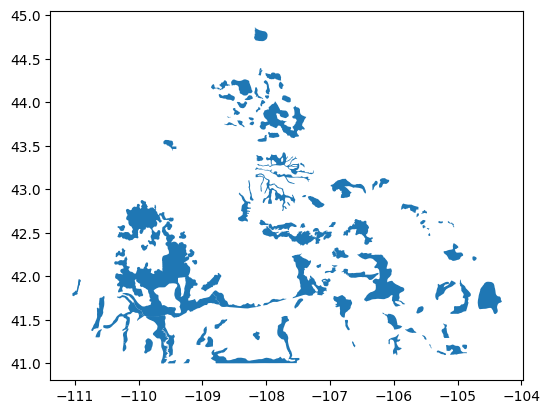

In [24]:
antelope_gdf.plot()

In [25]:
antelope_gdf.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

We can delete the file like this:

In [26]:
s3.delete_object(Bucket='dataclinic-nwf', Key='antelope_test.zip')

{'ResponseMetadata': {'RequestId': '2EVDB5BMS0ZNNY1H',
  'HostId': 'QIu8Qdn0c+U1DD2KMVFXIzc20akzL3RIeWj02ASXmR/nfCfTUVtXMXKvbE4OTA+SEu18035Wvng=',
  'HTTPStatusCode': 204,
  'HTTPHeaders': {'x-amz-id-2': 'QIu8Qdn0c+U1DD2KMVFXIzc20akzL3RIeWj02ASXmR/nfCfTUVtXMXKvbE4OTA+SEu18035Wvng=',
   'x-amz-request-id': '2EVDB5BMS0ZNNY1H',
   'date': 'Tue, 09 Apr 2024 17:54:21 GMT',
   'server': 'AmazonS3'},
  'RetryAttempts': 0}}